# PCA Strategy: Flatteners and Steepeners

Given the PCA Var-Cov decomposition, we are going to conduct a strategy that is neutral to changes in the level of the curve (PC1 neutral), and delta neutral. 

Our PCA decomposition looks like the following:

$$  F_t = \Delta y_{t} E$$
$$ \Delta y_{t} = F_t E^T$$ 

Where:

- $\Delta y_t$ is $(n, m)$ matrix with $n =$ number of periods in-sample and $m$ maturities in our yield curve (30).
- $F_t$ is the  $(n, f)$ matrix  of series of PCA scores, with $f$ number of factors to project (3 in our baseline case, ~97\% variance explained)
- $E$ $(f, m)$ matrix of eigenvectors of the decomposition of $\Sigma$, i.e. the loading of each PCA factor of each maturity. 

## Steepeners and Flatteners

The two strategies that we will pursue are Steepeners and Flatteners:

- Steepener:
    - Upward sloping curve: long front end /short long end 
- Flattener: 
    - Upward sloping curve: short front end /long long end

We choose a set of pairs of shorter/longer rates, such as 2vs20, 6Mvs5Y, 3Mvs7Y and so on. For any pair, we defined a portfolio with weights $w_1, w_2$ such that the $i$-th portfolio strategy $ i = 1,....,N$, $\Pi^i_t$, is neutral to $\text{PCA}_1$ factor: 

$$ \Pi^i_t =  w_1 \cdot \Delta y^s_t + w_2 \cdot \Delta y^l_t$$
$$ \partial_{\text{PCA}_1} \Pi^i_t = w_1 \partial_{\text{PCA}_1} \Delta y^s_t + w_2\partial_{\text{PCA}_1}\Delta y^l_t = 0 $$

We know that from the PCA decompositions $\partial_{\text{PCA}_1} \Delta y^s_t = E_{(1, \Delta y^j_t)}, j = s,l$, the respective loading from the eigenvectors. Furthermore, we restrict $w_1 + w_2 = 0$ or $w_1 = -w_2$ to have a delta nuetral portfolio.

$$ w_1 \partial_{\text{PCA}_1} \Delta y^s_t + w_2\partial_{\text{PCA}_1}\Delta y^l_t = 0$$
$$ w_1 E_{(1, \Delta y^s_t)} + w_2 E_{(1, \Delta y^l_t)} = 0$$

Additionally, we would like to have unit exposure to PCA2:

$$ w_1 E_{(2, \Delta y^s_t)} + w_2 E_{(2, \Delta y^l_t)} = 1$$


## Entry signal


Our entry signal is dervied from the Z-score of the portfolio given, where the mean and standard deviation are derived from a fix (but probably rolling) window, as:

$$\text{Z-score}^i = \frac{\Pi^t - \bar{\Pi^i}}{\sigma_{\Pi^i}}$$


We would enter a trade for $\text{Z-score} \geq |2|$ two or more standar deviation events. 









# Vizualization of strategy

## Differences in rates $\Delta y^i_t$
In what follows we use as example the spread 2vs10Y daily differences in swap rates (spot).

In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import module_joaquin as mod

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
spot_df = pd.read_csv("data/spot_sofr.csv",
                      parse_dates=["Dates"], header=0)
spot_df = spot_df.set_index("Dates")
spot_df = spot_df.apply(pd.to_numeric, errors="coerce").dropna()
print("Start date in sample = {t}".format(t = spot_df.index[0].strftime("%A, %B %d, %Y")))
print("End date in sample = {t}".format(t = spot_df.index[-1].strftime("%A, %B %d, %Y")))
print("Number of daily observations = {n}".format(n = spot_df.shape[0]))
print("Number of maturities = {m}".format(m = spot_df.shape[1]))
print("Maturities = {ml}".format(ml = list(spot_df.columns)))

Start date in sample = Friday, January 01, 2021
End date in sample = Friday, October 31, 2025
Number of daily observations = 1227
Number of maturities = 30
Maturities = ['1W', '2W', '3W', '1M', '2M', '3M', '4M', '5M', '6M', '7M', '8M', '9M', '10M', '11M', '12M', '18M', '2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y']


<Axes: >

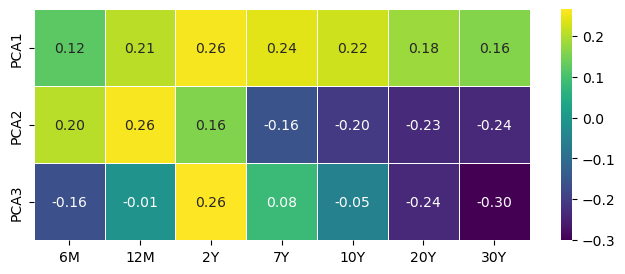

In [ ]:
from sklearn.decomposition import PCA

spot_diff = spot_df.diff(1).dropna()
n_mats = len(spot_diff.columns)

train_start_date = "2021-01-01"
train_end_date = "2023-12-29"
test_start_date = "2024-01-01"
test_end_date = "2025-10-31"

training_sample = spot_diff.loc[train_start_date:train_end_date]
test_sample = spot_diff.loc[test_start_date:test_end_date]
pca = PCA(n_components=3).fit(training_sample)
E_matrix = pca.components_

selected_maturities = ["6M", "12M", "2Y", "7Y", "10Y", "20Y", "30Y"]

E_display = pd.DataFrame(E_matrix, columns=spot_diff.columns, index=["PCA1", "PCA2", "PCA3"])[selected_maturities]
plt.figure(figsize=(8, 3))
sns.heatmap(E_display, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)


To compute the weights, we would need to solve the system:

$$w_1*0.26 + w_2*0.22 = 0$$
$$w_1*0.16 + w_2*(-0.20) = 1$$

In [36]:
E_pc1_2Y = E_matrix[0, spot_diff.columns.get_loc("2Y")]
E_pc1_10Y = E_matrix[0, spot_diff.columns.get_loc("10Y")]
E_pc2_2Y = E_matrix[1, spot_diff.columns.get_loc("2Y")]
E_pc2_10Y = E_matrix[1, spot_diff.columns.get_loc("10Y")]

A = np.array([
    [E_pc1_2Y, E_pc1_10Y],  # Row 1: PC1 Neutrality Constraint
    [E_pc2_2Y, E_pc2_10Y]   # Row 2: PC2 Exposure Constraint (Set K=1 for unit exposure)
])
# B: The vector of constraints
K = 1 # Unit exposure to PC2
B = np.array([0, K]) 

weights = np.linalg.solve(A, B) 
w_1 = weights[0]
w_2 = weights[1]

print(f"Weight for 2Y swap: {w_1:.4f}")
print(f"Weight for 10Y swap: {w_2:.4f}")

normalized_weights = weights /w_1
w_1_normalized = normalized_weights[0]
w_2_normalized = normalized_weights[1]
print(f"Normalized Weight for 2Y swap: {w_1_normalized:.4f}")
print(f"Normalized Weight for 10Y swap: {w_2_normalized:.4f}")

Weight for 2Y swap: 2.5507
Weight for 10Y swap: -2.9447
Normalized Weight for 2Y swap: 1.0000
Normalized Weight for 10Y swap: -1.1545


Our spread with exposure to PCA 2 component is therefore:

$$\Pi^{\text{2vs10}}_t = 1 \cdot \Delta \text{2Y}_t -  1.1545 \cdot \Delta \text{10Y}_t$$

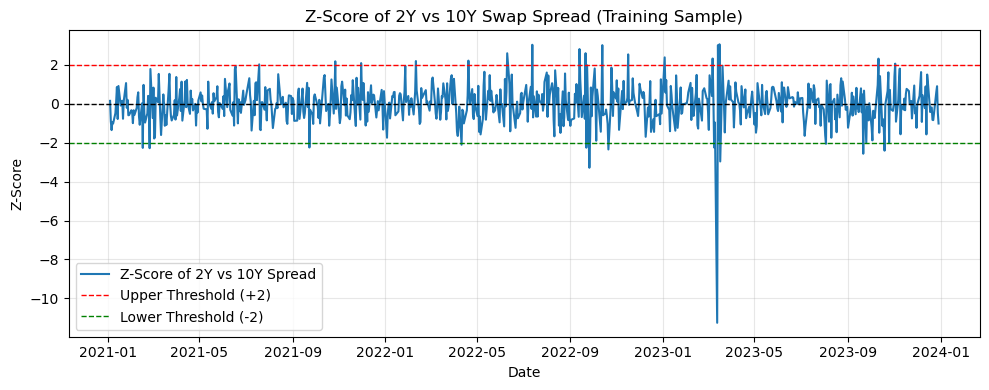

In [ ]:
spread_2vs10 = w_1_normalized * training_sample["2Y"] + w_2_normalized * training_sample["10Y"]
mean_spread = spread_2vs10.mean()
std_spread = spread_2vs10.std()
z_score_2vs10 = (spread_2vs10 - mean_spread) / std_spread

plt.figure(figsize=(10, 4))
plt.plot(z_score_2vs10.index, z_score_2vs10, label="Z-Score of 2Y vs 10Y Spread")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(2.0, color='red', linestyle='--', linewidth=1, label='Upper Threshold (+2)')
plt.axhline(-2.0, color='green', linestyle='--', linewidth=1, label='Lower Threshold (-2)')
plt.title("Z-Score of 2Y vs 10Y Swap Spread (Training Sample)")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


The out-of-sample signal for entering the trade on the spread, along with the spread in levels, would look like:

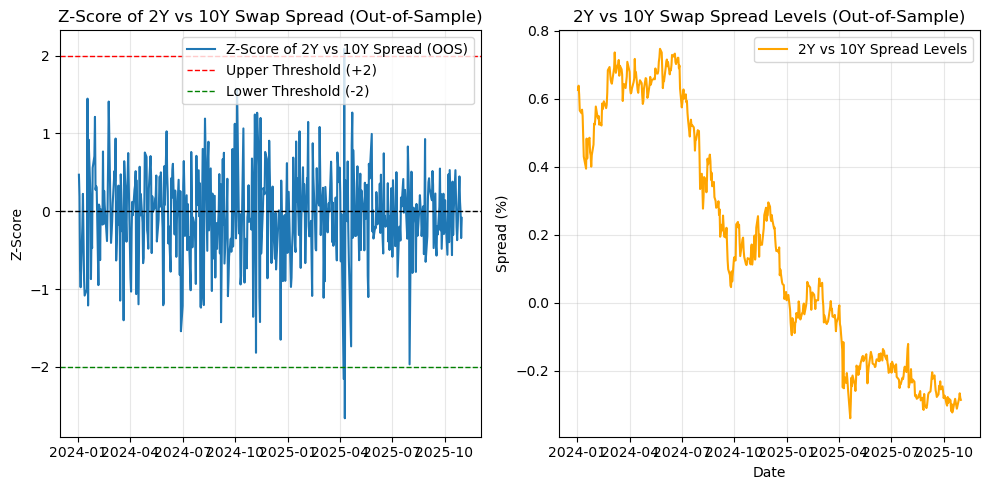

Z-score >0 signal ['2025-04-09T00:00:00.000000000']
Z-score <0 signal ['2025-04-08T00:00:00.000000000' '2025-04-10T00:00:00.000000000']


In [ ]:
spread_2vs10_oos = w_1_normalized * test_sample["2Y"] + w_2_normalized * test_sample["10Y"]
spread_2vs10_oos_levels = w_1_normalized * spot_df["2Y"].loc[test_start_date:test_end_date] + w_2_normalized * spot_df["10Y"].loc[test_start_date:test_end_date]
z_score_2vs10_oos = (spread_2vs10_oos - mean_spread) / std_spread


spread_2vs10_levels = spot_df["2Y"].loc[test_start_date:test_end_date] - spot_df["10Y"].loc[test_start_date:test_end_date]

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
ax[0].plot(z_score_2vs10_oos.index, z_score_2vs10_oos, label="Z-Score of 2Y vs 10Y Spread (OOS)")
ax[0].axhline(0, color='black', linestyle='--', linewidth=1)
ax[0].axhline(2.0, color='red', linestyle='--', linewidth=1, label='Upper Threshold (+2)')
ax[0].axhline(-2.0, color='green', linestyle='--', linewidth=1, label='Lower Threshold (-2)')
ax[0].set_title("Z-Score of 2Y vs 10Y Swap Spread (Out-of-Sample)")
ax[0].set_ylabel("Z-Score")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(spread_2vs10_levels.index, spread_2vs10_levels, label="2Y vs 10Y Spread Levels", color='orange')
ax[1].set_title("2Y vs 10Y Swap Spread Levels (Out-of-Sample)")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Spread (%)")
ax[1].legend()
ax[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Z-score >0 signal" , z_score_2vs10_oos[z_score_2vs10_oos > 2.0].index.values)
print("Z-score <0 signal" , z_score_2vs10_oos[z_score_2vs10_oos < -2.0].index.values)


## Strategy with levels $y^i_t$

Below we work with the swap rates in levels

<Axes: >

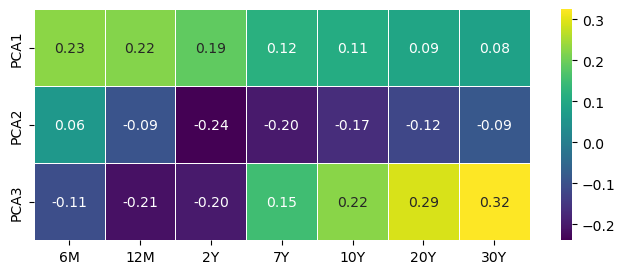

In [54]:
training_sample_levels = spot_df.loc[train_start_date:train_end_date]
test_sample_levels = spot_df.loc[test_start_date:test_end_date]
pca_levels = PCA(n_components=3).fit(training_sample_levels)
E_matrix_levels = pca_levels.components_

selected_maturities = ["6M", "12M", "2Y", "7Y", "10Y", "20Y", "30Y"]

E_levels_display = pd.DataFrame(E_matrix_levels, columns=spot_df.columns, index=["PCA1", "PCA2", "PCA3"])[selected_maturities]
plt.figure(figsize=(8, 3))
sns.heatmap(E_levels_display, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)

In [56]:
E_pc1_2Y_levels = E_matrix_levels[0, spot_df.columns.get_loc("2Y")]
E_pc1_10Y_levels = E_matrix_levels[0, spot_df.columns.get_loc("10Y")]
E_pc2_2Y_levels = E_matrix_levels[1, spot_df.columns.get_loc("2Y")]
E_pc2_10Y_levels = E_matrix_levels[1, spot_df.columns.get_loc("10Y")]

A_levels = np.array([
    [E_pc1_2Y_levels, E_pc1_10Y_levels],  # Row 1: PC1 Neutrality Constraint
    [E_pc2_2Y_levels, E_pc2_10Y_levels]   # Row 2: PC2 Exposure Constraint (Set K=1 for unit exposure)
])
# B: The vector of constraints
K = 1 # Unit exposure to PC2
B = np.array([0, K]) 

weights_levels = np.linalg.solve(A_levels, B) 
w_1_levels = weights_levels[0]
w_2_levels = weights_levels[1]

print(f"Weight for 2Y swap: {w_1_levels:.4f}")
print(f"Weight for 10Y swap: {w_2_levels:.4f}")

normalized_weights_levels = weights_levels /w_1_levels
w_1_levels_normalized = normalized_weights_levels[0]
w_2_levels_normalized = normalized_weights_levels[1]
print(f"Normalized Weight for 2Y swap: {w_1_levels_normalized:.4f}")
print(f"Normalized Weight for 10Y swap: {w_2_levels_normalized:.4f}")

Weight for 2Y swap: 18.8315
Weight for 10Y swap: -32.7402
Normalized Weight for 2Y swap: 1.0000
Normalized Weight for 10Y swap: -1.7386


Mean of spread levels (training sample):  -1.8086407293651101
Standard Deviation of spread levels (training sample):  0.3559666211262862


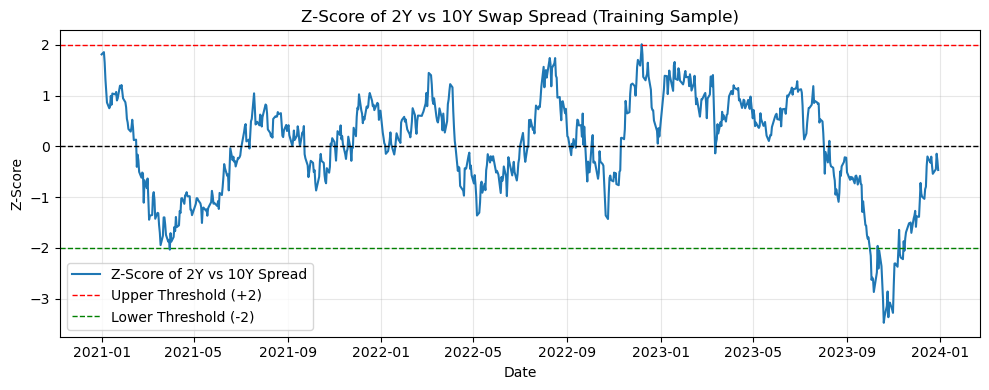

In [70]:
spread_2vs10_levels = w_1_levels_normalized * spot_df["2Y"].loc[train_start_date:train_end_date] + w_2_levels_normalized * spot_df["10Y"].loc[train_start_date:train_end_date]
mean_spread_levels = spread_2vs10_levels.mean()
std_spread_levels = spread_2vs10_levels.std()
z_score_2vs10_levels = (spread_2vs10_levels - mean_spread_levels) / std_spread_levels

print("Mean of spread levels (training sample): ", mean_spread_levels)
print("Standard Deviation of spread levels (training sample): ", std_spread_levels)

plt.figure(figsize=(10, 4))
plt.plot(z_score_2vs10_levels.index, z_score_2vs10_levels, label="Z-Score of 2Y vs 10Y Spread")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.axhline(2.0, color='red', linestyle='--', linewidth=1, label='Upper Threshold (+2)')
plt.axhline(-2.0, color='green', linestyle='--', linewidth=1, label='Lower Threshold (-2)')
plt.title("Z-Score of 2Y vs 10Y Swap Spread (Training Sample)")
plt.xlabel("Date")
plt.ylabel("Z-Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


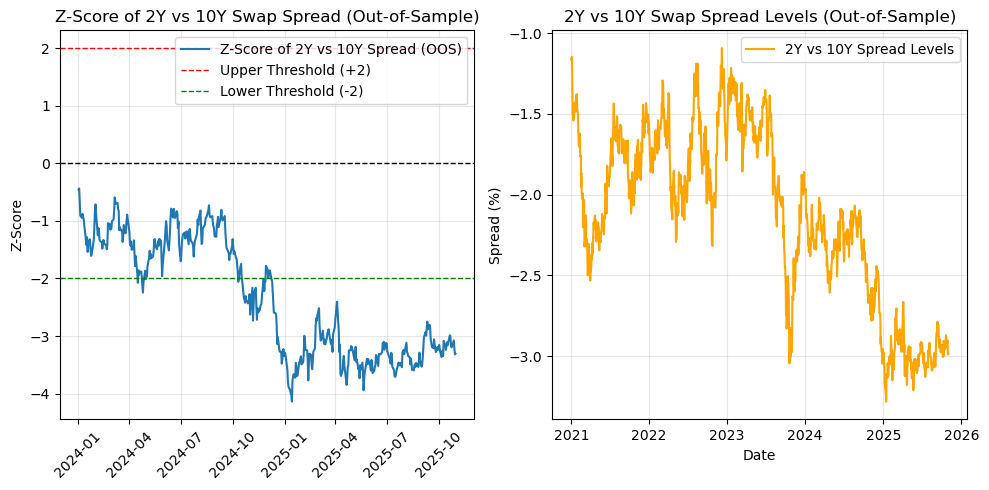

Z-score >0 signal []
Z-score <0 signal ['2024-04-16T00:00:00.000000000' '2024-04-24T00:00:00.000000000'
 '2024-04-25T00:00:00.000000000' '2024-04-26T00:00:00.000000000'
 '2024-04-30T00:00:00.000000000' '2024-10-11T00:00:00.000000000'
 '2024-10-17T00:00:00.000000000' '2024-10-18T00:00:00.000000000'
 '2024-10-21T00:00:00.000000000' '2024-10-22T00:00:00.000000000'
 '2024-10-23T00:00:00.000000000' '2024-10-24T00:00:00.000000000'
 '2024-10-25T00:00:00.000000000' '2024-10-28T00:00:00.000000000'
 '2024-10-29T00:00:00.000000000' '2024-10-30T00:00:00.000000000'
 '2024-10-31T00:00:00.000000000' '2024-11-01T00:00:00.000000000'
 '2024-11-04T00:00:00.000000000' '2024-11-05T00:00:00.000000000'
 '2024-11-06T00:00:00.000000000' '2024-11-07T00:00:00.000000000'
 '2024-11-08T00:00:00.000000000' '2024-11-11T00:00:00.000000000'
 '2024-11-12T00:00:00.000000000' '2024-11-13T00:00:00.000000000'
 '2024-11-14T00:00:00.000000000' '2024-11-15T00:00:00.000000000'
 '2024-11-18T00:00:00.000000000' '2024-11-19T00:00:

In [72]:
spread_2vs10_oos_levels = w_1_levels_normalized * spot_df["2Y"].loc[test_start_date:test_end_date] + w_2_levels_normalized * spot_df["10Y"].loc[test_start_date:test_end_date]
z_score_2vs10_oos_levels = (spread_2vs10_oos_levels - mean_spread_levels) / std_spread_levels

spread_2vs10_levels = (w_1_levels_normalized *spot_df["2Y"].loc[train_start_date:test_end_date] + w_2_levels_normalized *spot_df["10Y"].loc[train_start_date:test_end_date])

fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=False)
ax[0].plot(z_score_2vs10_oos_levels.index, z_score_2vs10_oos_levels, label="Z-Score of 2Y vs 10Y Spread (OOS)")
ax[0].axhline(0, color='black', linestyle='--', linewidth=1)
ax[0].axhline(2.0, color='red', linestyle='--', linewidth=1, label='Upper Threshold (+2)')
ax[0].axhline(-2.0, color='green', linestyle='--', linewidth=1, label='Lower Threshold (-2)')
ax[0].set_title("Z-Score of 2Y vs 10Y Swap Spread (Out-of-Sample)")
ax[0].set_ylabel("Z-Score")
ax[0].tick_params(axis='x', labelrotation=45) 
ax[0].legend()
ax[0].grid(True, alpha=0.3)

ax[1].plot(spread_2vs10_levels.index, spread_2vs10_levels, label="2Y vs 10Y Spread Levels", color='orange')
ax[1].set_title("2Y vs 10Y Swap Spread Levels (Out-of-Sample)")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Spread (%)")
ax[1].legend()
ax[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Z-score >0 signal" , z_score_2vs10_oos_levels[z_score_2vs10_oos_levels > 2.0].index.values)
print("Z-score <0 signal" , z_score_2vs10_oos_levels[z_score_2vs10_oos_levels < -2.0].index.values)
